## iPyLeaflet
[ipyleaflet](https://github.com/ellisonbg/ipyleaflet) is a bridge between jupyter notebooks and the [leaflet](http://leafletjs.com/)  javascript library for drawing maps.

ipyleaflet comes with a few examples notebooks (this notebook was derived from one) but very little documentation,
for more documentation read the [Leaflet IPA](http://leafletjs.com/reference.html)

For installation directions, see the README on [ipyleaflet](https://github.com/ellisonbg/ipyleaflet)

In [9]:
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl,
    Control, Widget
)

## Visualizing the distribution of the observations

## Load the required libraries

In [10]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math

In [1]:
import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

In [2]:
import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from computeStats import computeOverAllDist, STAT_Descriptions

In [3]:
### Read the data frame from pickle file

data_dir='../../Data/Weather'
#file_index='BBBSBBBB'
file_index='BSBSSSBB'
meas='TOBS'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print('keys from STAT=',STAT.keys())

#!ls -ld $data_dir/*.parquet

#read data
filename=data_dir+'/decon_%s_%s.parquet'%(file_index,meas)

df=sqlContext.read.parquet(filename)
print(df.count())
df.show(2)

('keys from STAT=', ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP'])
1424
+-----------------+------------------+-------------------+---------+--------+--------+---------+-----------+------------------+------------------+------------------+-------------------+-----------+---------+------+--------------------+------+
|          coeff_1|           coeff_2|            coeff_3|elevation|   label|latitude|longitude|measurement|             res_1|             res_2|             res_3|           res_mean|    station|total_var|undefs|              vector|  year|
+-----------------+------------------+-------------------+---------+--------+--------+---------+-----------+------------------+------------------+------------------+-------------------+-----------+---------+------+--------------------+------+
|951.3156042742843|-36.86447687289478|-232.83629691576016|     46.9|BSBSSSBB| 31.0833| -82.5653|       TOBS|0.4872809225033287|0.4865110011103735|0.4557973389173408|0.19826879475154144|USC00095492

In [4]:
#extract longitude and latitude for each station
feature='coeff_1'
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT station, latitude,longitude,elevation,%s FROM weather"%feature
print(Query)
df1 = sqlContext.sql(Query)
df1.show(4)

SELECT station, latitude,longitude,elevation,coeff_1 FROM weather
+-----------+--------+---------+---------+------------------+
|    station|latitude|longitude|elevation|           coeff_1|
+-----------+--------+---------+---------+------------------+
|USC00095492| 31.0833| -82.5653|     46.9| 951.3156042742843|
|USC00095386| 31.9297| -82.6792|     36.6| 862.3642009136354|
|USC00098476| 31.7078| -82.1969|     61.0|-921.4317214854921|
|USC00093465|   30.74| -82.1278|     36.6|-683.0455129943923|
+-----------+--------+---------+---------+------------------+
only showing top 4 rows



In [5]:
df2=df1.groupby(['station','latitude','longitude','elevation']).agg({"station": "count", feature: "mean"})
pdf=df2.toPandas()
pdf.sort_values(by=['station'],inplace=True)
pdf.head(2)

,station,latitude,longitude,elevation,count(station),avg(coeff_1)
1,USC00083470,30.2717,-82.1856,39.0,62,-210.350591
22,USC00084393,30.5333,-83.0167,46.0,7,-664.603677


In [19]:
#define a mapping from the range of the value to hex colors.
from matplotlib.colors import rgb2hex
_avg='avg(%s)'%feature
_min=pdf[_avg].min()
_max=pdf[_avg].max()
_min,_max

import pylab as plt
cmap=plt.get_cmap('autumn')
def get_color(val):
    x=(val-_min)/(_max-_min)
    return(rgb2hex(cmap(x)[:3]))

get_color(1000.)

u'#ffe100'

## Map

In [7]:
# Max Lat 33.2833
# Min Lat 30.1853
# Min Lon -83.4681
# Max Lon -82.0314

min_lat,max_lat,min_long,max_long = box = (30, 34, -84, -82)


In [53]:
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 9

m = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)

# r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
# m += r
coeff_avg = []
lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
circles = []
for index,row in pdf.iterrows():
    _lat=row['latitude']
    _long=row['longitude']
    _count=row['count(station)']
    _coef=row[_avg]
    # taking sqrt of count so that the  area of the circle corresponds to the count
    c = Circle(location=(_lat,_long), radius=int(600*np.sqrt(_count+0.0)), weight=1,
            color='#F00', opacity=0.8, fill_opacity=0.8,
            fill_color=get_color(_coef))
    coeff_avg.append(_coef)
    circles.append(c)
    m.add_layer(c)
    
h=6
w=-43
io = ImageOverlay(url='legend_.png', bounds=[[37.082-h, -122-w], [37.9-h, -122.8-w]])
m.add_layer(io)

m



### excercises:
* Add a legend that relates the colors to values.
* Leaflet supports a variety of maps. See if you can get a topographical map as the background.

In [26]:
#get_color(min(coeff_avg)), get_color(max(coeff_avg))
min(coeff_avg), max(coeff_avg)
#red, yellow


(-978.2897992987957, 1270.1593387648172)

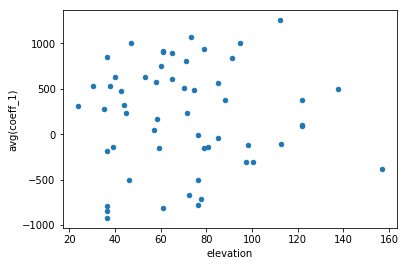

In [23]:
%matplotlib inline
pdf.plot.scatter(x='elevation',y='avg(coeff_1)');

In [44]:
wid = Widget()?
legend = Control()
legend.add_traits
m+=legend
m.add_control(legend)

SyntaxError: invalid syntax (<ipython-input-44-3942fcdd9cb7>, line 1)

In [45]:
Widget?

In [21]:
RDD1=sc.parallelize(["spark  basics", "spark big  data analysis", "spring"]) 
RDD2=sc.parallelize(["spark using pyspark", "big data"])
 
RDD1.subtract(RDD2).collect()

['spark big  data analysis', 'spring', 'spark  basics']